In [39]:
import pandas as pd
import numpy as np
from scipy import stats as st
import json
import os
import unicodedata
from collections import defaultdict
import networkx as nx
import matplotlib.pyplot as plt
from fa2 import ForceAtlas2
from functools import reduce
%matplotlib inline

In [2]:
forceatlas2 = ForceAtlas2(
    # Behavior alternatives
    outboundAttractionDistribution=True,  # Dissuade hubs
    linLogMode=False,  # NOT IMPLEMENTED
    adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
    edgeWeightInfluence=1.0,

    # Performance
    jitterTolerance=1.0,  # Tolerance
    barnesHutOptimize=True,
    barnesHutTheta=1.2,
    multiThreaded=False,  # NOT IMPLEMENTED

    # Tuning
    scalingRatio=2.0,
    strongGravityMode=False,
    gravity=1.0,

    # Log
    verbose=True)

In [3]:
instagram_data_dir = "instagram_100_sessions/Compiled and Totaled Sessions 2020"

In [4]:
xl_file_names = [os.path.join(instagram_data_dir, x) for x in os.listdir(instagram_data_dir) if x.endswith('.xlsx') and 'Totals' not in x]

In [5]:
xl_files = [os.path.join(instagram_data_dir, x) for x in os.listdir(instagram_data_dir) if x.endswith('.xlsx') and 'Totals' not in x]

In [6]:
xl_files

['instagram_100_sessions/Compiled and Totaled Sessions 2020/CB IG Compiled Coding Set 1 - 2020 (Revised 2.0).xlsx',
 'instagram_100_sessions/Compiled and Totaled Sessions 2020/CB IG Compiled Coding Set 2 - 2020 (Revised 2.0).xlsx',
 'instagram_100_sessions/Compiled and Totaled Sessions 2020/CB IG Compiled Coding Set 5 - 2020 (Revised 2.0).xlsx',
 'instagram_100_sessions/Compiled and Totaled Sessions 2020/CB IG Compiled Coding Set 3 - 2020 (Revised 2.0).xlsx',
 'instagram_100_sessions/Compiled and Totaled Sessions 2020/CB IG Compiled Coding Set 4 - 2020 (Revised 2.0).xlsx']

In [7]:
t_xl_file = pd.ExcelFile(xl_files[0])

In [8]:
t_xl_file.sheet_names

['1 Overall CB - Yes',
 '2 Overall CB - No',
 '3 Overall CB - No',
 '4 Overall CB - No',
 '5 Overall CB - No',
 '6 Overall CB - No',
 '7 Overall CB - No',
 '8 Overall CB - Yes',
 '9 Overall CB - No',
 '10 Overall CB - No',
 '11 Overall CB - No',
 '12 Overall CB - No',
 '13 Overall CB - Yes',
 '14 Overall CB - No',
 '15 Overall CB - No',
 '16 Overall CB - No',
 '17 Overall CB - Yes',
 '18 Overall CB - Yes',
 '19 Overall CB - No',
 '20 Overall CB - Yes']

In [9]:
pd.read_excel(t_xl_file, t_xl_file.sheet_names[1])

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,CB Comment: Whether comment overall was a CB comment or not (1= CB 0= No CB),Content: The type of CB used in the comment,"1= Sexual; but NOT sexual/gender identity (e.g. ""whore"") 0= N/A",Unnamed: 7,Unnamed: 8,"1= Sexual orientation/gender identity (e.g. ""gay"") 0= N/A",...,Unnamed: 41,1= Suicide 0= N/A,Unnamed: 43,Unnamed: 44,1= Stress (or anxiety) 0= N/A,Unnamed: 46,Unnamed: 47,1= Discrimination 0= N/A,Unnamed: 49,Unnamed: 50
0,witneycarson,NaN,Anyone see the Pepsi halftime show commercial ...,Media posted at 2014-01-27 03:59:56\n\n,CB_Comment,NaN,Content_A,NaN,NaN,Content_B,...,NaN,OP_B,NaN,NaN,OP_C,NaN,NaN,OP_D,NaN,NaN
1,Comment Number,Commenter Username,Comment,Comment Post Time,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,britterkritter,I seen you!,(created_at:2014-01-27 04:10:11),0,NaN,NaN,NaN,NaN,NaN,...,0.0,0,NaN,0.0,0,NaN,0.0,0,NaN,0.0
3,2,caitlynirenie,Get it girl!!!,(created_at:2014-01-27 04:19:24),0,NaN,NaN,NaN,NaN,NaN,...,0.0,0,NaN,0.0,0,NaN,0.0,0,NaN,0.0
4,3,alnsalzr,Loved it Wit,(created_at:2014-01-27 04:22:34),0,NaN,NaN,NaN,NaN,NaN,...,0.0,0,NaN,0.0,0,NaN,0.0,0,NaN,0.0
5,4,aftonnoelle,We saw it.. Damn girl,(created_at:2014-01-27 04:54:38),0,NaN,NaN,NaN,NaN,NaN,...,0.0,0,NaN,0.0,0,NaN,0.0,0,NaN,0.0
6,5,shashtay,_Å½Ã›Â_Å½â€šÂ so awesome!!,(created_at:2014-01-27 04:55:26),0,NaN,NaN,NaN,NaN,NaN,...,0.0,0,NaN,0.0,0,NaN,0.0,0,NaN,0.0
7,6,darlahood7,Loved it!!!,(created_at:2014-01-27 04:56:47),0,NaN,NaN,NaN,NaN,NaN,...,0.0,0,NaN,0.0,0,NaN,0.0,0,NaN,0.0
8,7,laceyleabell,You're the cutest little bad ass ever. :),(created_at:2014-01-27 05:24:25),0,NaN,NaN,NaN,NaN,NaN,...,0.0,0,NaN,0.0,0,NaN,0.0,0,NaN,0.0
9,8,vad_a,I haven't seen any of those dudes. I was watch...,(created_at:2014-01-27 05:25:43),0,NaN,,NaN,NaN,NaN,...,0.0,0,NaN,0.0,0,NaN,0.0,0,NaN,0.0


## Get all the excel sessions
Each file represents a set of sessions
Each Session is labeled bullying or non bullying in the sheet name
Following is the planned representation
```
{
    session:       str
    poster:        str
    text:          str
    session_label: int
    comments:
        {
            poster:        str
            directed_to:   str
            text:          str
            comment_label: int
        }
}
```

In [10]:
xl_files = [pd.ExcelFile(x) for x in xl_files]

In [11]:
def get_session_info(excel_file: pd.ExcelFile, sheet_name: str):
    str_label = sheet_name.split('-')[1].strip()
    int_label = 0 if str_label.lower() == 'no' else 1

    sheet_content = pd.read_excel(excel_file, sheet_name)
    columns = sheet_content.columns
    poster_name = sheet_content[sheet_content.columns[0]][0]
    poster_name = poster_name.strip()
    poster_comment = sheet_content[sheet_content.columns[2]][0]

    # parse all the comments
    comment_posters= sheet_content[2:][columns[1]].tolist()
    comment_texts  = sheet_content[2:][columns[2]].tolist()
    comment_labels = sheet_content[2:][columns[4]].tolist()
    directions   = [list(sheet_content[2:][columns[x]].to_list()) for x in [35, 36, 37]]
    directions = list(zip(*directions))
    comments = []
    # create a structure from the extracted data
    for i in range(len(comment_posters)):
        # print(directions[i])
        try:
            comments.append({
                'user': comment_posters[i].strip(),
                'to': [x.strip().replace('@', '') if not pd.isna(x) and type(x) == str else '' for x in directions[i]],
                'content': comment_texts[i].strip(),
                'label': int(comment_labels[i])
            })
        except Exception as e:
            print('=' * 10)
            print(e)
            print('=' * 10)
            print(comment_posters[i])
            print(directions[i])
            print(comment_texts[i])
            print(comment_labels[i])

    session = {
        'session': sheet_name,
        'user': poster_name,
        'content': poster_comment.strip(),
        'label': int_label,
        'comments': comments
    }

    return session


In [12]:
# Get the session information for all the sessions
sessions = []
for file_i, xl_file in enumerate(xl_files):
    print(f'Doing {xl_file_names[file_i]}')
    for sheet in xl_file.sheet_names:
        print(f'Doing sheet {sheet}')
        session_info = get_session_info(xl_file, sheet)
        sessions.append(session_info)

Doing instagram_100_sessions/Compiled and Totaled Sessions 2020/CB IG Compiled Coding Set 1 - 2020 (Revised 2.0).xlsx
Doing sheet 1 Overall CB - Yes
Doing sheet 2 Overall CB - No
Doing sheet 3 Overall CB - No
Doing sheet 4 Overall CB - No
Doing sheet 5 Overall CB - No
cannot convert float NaN to integer
louiscabb
(nan, nan, nan)
So would it take a additional 7days to arrive or how much? 
nan
Doing sheet 6 Overall CB - No
Doing sheet 7 Overall CB - No
cannot convert float NaN to integer
gianna_devincenzo
(nan, nan, nan)
@_brittany_keyes_ 
nan
Doing sheet 8 Overall CB - Yes
Doing sheet 9 Overall CB - No
Doing sheet 10 Overall CB - No
Doing sheet 11 Overall CB - No
Doing sheet 12 Overall CB - No
Doing sheet 13 Overall CB - Yes
Doing sheet 14 Overall CB - No
Doing sheet 15 Overall CB - No
Doing sheet 16 Overall CB - No
'float' object has no attribute 'strip'
elyse_turney
(nan, nan, nan)
nan
0
Doing sheet 17 Overall CB - Yes
Doing sheet 18 Overall CB - Yes
Doing sheet 19 Overall CB - No
Doi

In [13]:
len(sessions)

100

## Create a graph from the sessions

In [14]:
# get the set of unique users
users = []

for session in sessions:
    users.append(session['user'])
    users.extend([x['user'] for x in session['comments']])
    # Also add the people mentioned
    users.extend([y for x in session['comments'] for y in x['to']])


In [15]:
users = list(set(users))

In [16]:
user_bully_dict = defaultdict(lambda: {0: 0, 1: 0})
# For each user judge whether they were involved in bullying or not
for session in sessions:
    for comment in session['comments']:
        try:
            user = comment['user']
            label = comment['label']
            user_bully_dict[user][label] += 1
        except Exception as e:
            print(comment)




{'user': 'followthat', 'to': ['', 'blkbarbieswagg', 'blkbarbieswagg'], 'content': "You are a bad bitch not a queen ..don't confuse that shit..", 'label': 3}


In [17]:
user_bully_perc = {}
for k, v in user_bully_dict.items():
    if v[0] + v[1] == 0:
        perc = 0
    else:
        perc = v[1]/(v[0] + v[1])

    user_bully_perc[k] = perc

In [18]:
bullies = [k for k, v in user_bully_perc.items() if v>0]
nonbullies = [k for k, v in user_bully_perc.items() if v == 0]


In [19]:
len(bullies), len(nonbullies)

(587, 5927)

### Get the edges from the sessions

In [20]:
user_to_id = {}
id_to_user = {}
for i, user in enumerate(users):
    user_to_id[user] = i
    id_to_user[i] = user


In [21]:
edges = []
for session in sessions:
    for comment in session['comments']:
        try:
            to_mapped = [user_to_id[x] for x in comment['to'] if x != '']
            if len(to_mapped) == 0:
                continue
            e_to = st.mode(to_mapped).mode.item()
            e_from = user_to_id[comment['user']]
            edges.append((e_from, e_to))
        except Exception as e:
            print(e)
            print(to_mapped)



/tmp/ipykernel_2996676/857960562.py:8: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  e_to = st.mode(to_mapped).mode.item()


In [22]:
len(edges)

1869

In [23]:
G = nx.Graph()

In [24]:
G.add_nodes_from(list(id_to_user.keys()))
G.add_edges_from(edges)

In [34]:
len(bullies), len(nonbullies), len(users)

(587, 5927, 6920)

In [42]:
lcc = reduce(lambda a, b: b if len(b) > len(a) else a, nx.connected_components(G))

In [43]:
G = G.subgraph(lcc)

In [49]:
pos = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=2000)

100%|██████████| 2000/2000 [00:03<00:00, 564.66it/s]

BarnesHut Approximation  took  1.39  seconds
Repulsion forces  took  1.78  seconds
Gravitational forces  took  0.03  seconds
Attraction forces  took  0.01  seconds
AdjustSpeedAndApplyForces step  took  0.17  seconds


In [28]:
bullies_idx = [user_to_id[x] for x in bullies]
nonbullies_idx = [user_to_id[x] for x in nonbullies]

In [53]:
bullies_idx = [x for x in bullies_idx if x in G.nodes]
nonbullies_idx = [x for x in nonbullies_idx if x in G.nodes]

In [54]:
plt.clf()

<Figure size 432x288 with 0 Axes>

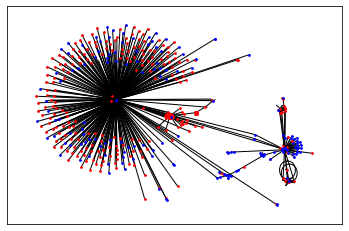

In [56]:
nx.draw_networkx_nodes(G, pos, nodelist=bullies_idx, node_color='#ff0000', node_size=3)
nx.draw_networkx_nodes(G, pos, nodelist=nonbullies_idx, node_color='#0000ff', node_size=3)
nx.draw_networkx_edges(G, pos)
plt.savefig('fig.svg')

In [26]:
t_sheet = pd.read_excel(xl_files[0])

In [32]:
t_sheet[t_sheet.columns[2]][0]

'gosh we love these five idiots so much __Â\x8f for me, they have seriously turned my life around and I am so thankful for that x ~Zhanna__Ã”"'

In [62]:
t_sheet[2:][t_sheet.columns[1]].tolist()

['lynnseyerinalexandra',
 'its_paynefull',
 'maria.azpiri',
 'myabvb',
 'a.k.watkins',
 'emilymcloone',
 'liz.crockett',
 'emilymorgan15',
 'signehugger',
 'niazki.lam',
 '69with_harryx',
 '69with_harryx',
 'supaaaabbyy',
 'cliffordslittlesecret',
 'boobguyniall',
 'eilisa.halpinbarnett',
 'cliffordslittlesecret',
 'cliffordslittlesecret',
 'emilyjbenson',
 'chiara_311',
 'asnatebedi',
 '_go_._away_',
 'dgillett18',
 'c.a.t.h.e.r.i.n.e',
 'just_luke_pics',
 'niallersparadise',
 'm.colantuono',
 'allison.ruth',
 '_helenhorton',
 'carolyn_salvatelli',
 'maggie.gleeson',
 'bellaaarinaaa',
 'amandaer99',
 'horuptionx',
 'miaiversenhuus',
 'beamiller666',
 'danamelisax',
 'ermstyles',
 'fancytomlinson',
 'itsmorgii',
 'thehoranteam',
 '_malisaurus_',
 'ptv.sammiee',
 'josiemarieking',
 'lauren_brady0405',
 '_emilyhost_',
 'maria.papas',
 'rexghxn',
 '_cassidilla',
 'sarahprovo4',
 'erin_epic6',
 'camryyn_',
 'mon_mon_96',
 'allyrubens',
 'morgannberry_15',
 'allison.byers',
 'sakandra212',


In [116]:
get_session_info(t_xl_file, t_xl_file.sheet_names[0])

{'session': '1 Overall CB - Yes',
 'user': 'maliksbby',
 'content': 'gosh we love these five idiots so much __Â\x8f for me, they have seriously turned my life around and I am so thankful for that x ~Zhanna__Ã”"',
 'label': 1,
 'comments': [{'user': 'lynnseyerinalexandra',
   'to': ['', '', ''],
   'content': 'Zaaaayn',
   'label': 0},
  {'user': 'its_paynefull',
   'to': ['', '', ''],
   'content': 'Larry',
   'label': 0},
  {'user': 'maria.azpiri',
   'to': ['', '', ''],
   'content': 'Niall_Å½Ã›_',
   'label': 0},
  {'user': 'myabvb',
   'to': ['', '', ''],
   'content': 'How do u get a gif? I cant aave them to my phone',
   'label': 0},
  {'user': 'a.k.watkins',
   'to': ['', '', ''],
   'content': 'Larry, Zayn being sexy, and Niall and Liam doing something stupid in the back',
   'label': 0},
  {'user': 'emilymcloone',
   'to': ['', '', ''],
   'content': '@sarahhlizzie _Å½Ã›__Å½â€šÂ´',
   'label': 0},
  {'user': 'liz.crockett',
   'to': ['', '', ''],
   'content': '@a_magnifecent_

In [80]:
a = zip([1,2,3], [4,5,6], [7, 8, 9])

In [76]:
list(a)[0]

IndexError: list index out of range

In [81]:
b = list(a)

In [83]:
b[0]

(1, 4, 7)

In [105]:
pd.isna(t_sheet[t_sheet.columns[35]][1])

True

In [18]:
import tweepy

In [5]:
data_dir = "/home/anique/projects/Interpretable-Multimodal-Hate-Speech/resources/MMHS_dataset"

In [7]:
with open(os.path.join(data_dir, 'train.txt'), 'r') as train_file:
    train_text = train_file.readlines()

In [11]:
train_data = [json.loads(x) for x in train_text]

In [13]:
train_df = pd.DataFrame(train_data)

In [33]:
train_df

,id,text,image_text,original_text,original_image_text,label,original_label
0,1114679353714016256,<user> nigga,youngeru save it,@FriskDontMiss Nigga https://t.co/cAsaLWEpue,#YOUNGERU SAVE IT,Hate,"[Religion, Racist, Homophobe]"
1,1063020048816660480,my horses are retarded,,My horses are retarded https://t.co/HYhqc6d5WN,,Hate,"[OtherHate, OtherHate, OtherHate]"
2,1108927368075374593,nigga on ma momma youngboy be spitting real sh...,,“NIGGA ON MA MOMMA YOUNGBOY BE SPITTING REAL S...,,NotHate,"[NotHate, NotHate, NotHate]"
3,1114558534635618305,rt xxsugvngxx i ran into this holy nigga today...,,RT xxSuGVNGxx: I ran into this HOLY NIGGA TODA...,,NotHate,"[Racist, NotHate, NotHate]"
4,1106978219654303744,real ass bitch give a fuck boutta nigga,,“ real ass bitch give a fuck boutta nigga” htt...,,NotHate,"[NotHate, NotHate, NotHate]"
...,...,...,...,...,...,...,...
134806,1114170734472048640,<user> i would just say hes donny the retard,late mogif late motiv,@svdate @gtconway3d I would just say hes Donny...,LATE MOGIF LATE MOTIV,Hate,"[Sexist, OtherHate, NotHate]"
134807,1110368198786846720,<user> congrats my nigga keep on grinding,on air elapsed time select your level reward o...,@Cheftime_Dev congrats my nigga keep on grindi...,ON AIR Elapsed Time: 05.47:18 Select Your Leve...,NotHate,"[NotHate, NotHate, NotHate]"
134808,1106941858540851200,my nigga big shitty,,My nigga big shitty https://t.co/e0snJGBgH9,,NotHate,"[NotHate, Racist, NotHate]"
134809,1105268309233188865,did she just say my nigga to rich she said it ...,,did she just say “my nigga” to Rich? &amp; she...,,NotHate,"[Racist, NotHate, NotHate]"


In [23]:
auth = tweepy.OAuth1UserHandler(
    "7PjXbGnOe0cHGbQhlJDd5vUlY",
    "UT9UlXKpXL59nG0iDh43mYVH3zubhyW2kuItQt04kDAPGKu05K",
    "3746388736-XhAIIODGhFyB1La0HXzxz8Iha6DJXGupSVvHV1x",
    "CPpT6oIw1YoMfnMS7iMtZgnACOU6idy84bomij2KUlteq"
)

In [24]:
api = tweepy.API(auth)

public_tweets = api.home_timeline()
for t in public_tweets:
    print(t.text)

After discussing it with our seniors we transferred the missing case to Delhi. We cannot say how &amp; when he murdered… https://t.co/LRl1s6KteJ
Mumbai | The (accused) man said they both used to live together in Delhi but she left him after a fight. His statem… https://t.co/YUptRDqIjE
What’s your current sentiment about crypto?
Zeldin: NY crime not going anywhere because election is over, residents tasked with deciding whether to stay https://t.co/vZXfqMkHNW
Biden says he and Xi have "responsibility" to show U.S., China can "manage our differences," find areas of cooperat… https://t.co/JWYKY0dCro
The vintage aircraft in Saturday's deadly collision at a Dallas air show, as expected, lacked flight data recorders… https://t.co/Rnii5DeCPZ
President Biden and his Chinese counterpart, Xi Jinping, will hold a face-to-face meeting in Bali. The talks comes… https://t.co/BSIunjMHCj
BREAKING: U.S. President Joe Biden, Chinese President Xi Jinping shake hands, open meeting aiming to "build a floor

In [70]:
import datasets

In [71]:
hate_severity_data = datasets.load_dataset('ucberkeley-dlab/measuring-hate-speech', 'binary')
df = hate_severity_data['train'].to_pandas()

Using custom data configuration ucberkeley-dlab--measuring-hate-speech-4f45d42aa1ce66f3


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

Dataset parquet downloaded and prepared to /home/anique/.cache/huggingface/datasets/ucberkeley-dlab___parquet/ucberkeley-dlab--measuring-hate-speech-4f45d42aa1ce66f3/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [73]:
df

,comment_id,annotator_id,platform,sentiment,respect,insult,humiliate,status,dehumanize,violence,...,annotator_religion_hindu,annotator_religion_jewish,annotator_religion_mormon,annotator_religion_muslim,annotator_religion_nothing,annotator_religion_other,annotator_sexuality_bisexual,annotator_sexuality_gay,annotator_sexuality_straight,annotator_sexuality_other
0,47777,10873,3,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,False,False,False,False,False,False,False,False,True,False
1,39773,2790,2,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,False,False,False,False,False,False,False,False,True,False
2,47101,3379,3,4.0,4.0,4.0,4.0,4.0,4.0,0.0,...,False,False,False,False,True,False,False,False,True,False
3,43625,7365,3,2.0,3.0,2.0,1.0,2.0,0.0,0.0,...,False,False,False,False,False,False,False,False,True,False
4,12538,488,0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,...,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135551,37080,8590,2,1.0,1.0,0.0,0.0,2.0,0.0,0.0,...,False,False,False,False,False,False,False,False,True,False
135552,22986,8303,2,2.0,0.0,0.0,0.0,2.0,0.0,0.0,...,False,False,False,False,False,True,True,False,False,False
135553,21008,6207,2,1.0,1.0,1.0,1.0,1.0,0.0,0.0,...,False,False,False,False,False,False,False,False,True,False
135554,22986,7886,2,2.0,0.0,0.0,0.0,2.0,0.0,0.0,...,False,False,False,False,True,False,False,False,True,False


In [74]:
hate_severity_data

DatasetDict({
    train: Dataset({
        features: ['comment_id', 'annotator_id', 'platform', 'sentiment', 'respect', 'insult', 'humiliate', 'status', 'dehumanize', 'violence', 'genocide', 'attack_defend', 'hatespeech', 'hate_speech_score', 'text', 'infitms', 'outfitms', 'annotator_severity', 'std_err', 'annotator_infitms', 'annotator_outfitms', 'hypothesis', 'target_race_asian', 'target_race_black', 'target_race_latinx', 'target_race_middle_eastern', 'target_race_native_american', 'target_race_pacific_islander', 'target_race_white', 'target_race_other', 'target_race', 'target_religion_atheist', 'target_religion_buddhist', 'target_religion_christian', 'target_religion_hindu', 'target_religion_jewish', 'target_religion_mormon', 'target_religion_muslim', 'target_religion_other', 'target_religion', 'target_origin_immigrant', 'target_origin_migrant_worker', 'target_origin_specific_country', 'target_origin_undocumented', 'target_origin_other', 'target_origin', 'target_gender_men', 'target

In [79]:
df[df['text'].str.contains('@')]['text']


12        @terryelaineh1 @UKLabour Why do 3.8 million #5...
16        @ghostofthor same energy as the "YOU DONT LOOK...
17        @suddenlywestan Because you are a country of m...
30                   @KeGutta These niggas straight bitches
36        @LT Wilson I think you are a joke for assuming...
                                ...                        
122412    @blackrepublican how long after the name chang...
122421    @blackrepublican how long after the name chang...
135549    Umar khalid, sahela rashid, kanhiyan kumar जैस...
135550    @AbeShinzo @realDonaldTrump @shinzoabe 独裁者は行きま...
135553    @AbeShinzo @realDonaldTrump @shinzoabe 独裁者は行きま...
Name: text, Length: 16305, dtype: object

In [80]:
df

,comment_id,annotator_id,platform,sentiment,respect,insult,humiliate,status,dehumanize,violence,...,annotator_religion_hindu,annotator_religion_jewish,annotator_religion_mormon,annotator_religion_muslim,annotator_religion_nothing,annotator_religion_other,annotator_sexuality_bisexual,annotator_sexuality_gay,annotator_sexuality_straight,annotator_sexuality_other
0,47777,10873,3,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,False,False,False,False,False,False,False,False,True,False
1,39773,2790,2,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,False,False,False,False,False,False,False,False,True,False
2,47101,3379,3,4.0,4.0,4.0,4.0,4.0,4.0,0.0,...,False,False,False,False,True,False,False,False,True,False
3,43625,7365,3,2.0,3.0,2.0,1.0,2.0,0.0,0.0,...,False,False,False,False,False,False,False,False,True,False
4,12538,488,0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,...,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135551,37080,8590,2,1.0,1.0,0.0,0.0,2.0,0.0,0.0,...,False,False,False,False,False,False,False,False,True,False
135552,22986,8303,2,2.0,0.0,0.0,0.0,2.0,0.0,0.0,...,False,False,False,False,False,True,True,False,False,False
135553,21008,6207,2,1.0,1.0,1.0,1.0,1.0,0.0,0.0,...,False,False,False,False,False,False,False,False,True,False
135554,22986,7886,2,2.0,0.0,0.0,0.0,2.0,0.0,0.0,...,False,False,False,False,True,False,False,False,True,False
